## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.). 



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models. 
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To suppress warnings
import warnings

warnings.filterwarnings("ignore")

#this package looks at all the columns in your dataframe and identifies possible cleaning tasks that need to be done, saving a massive amount of time and code.
from pandas_dq import dq_report as dqr


Imported pandas_dq (1.12). Always upgrade to get latest features.



## Loading the dataset

In [2]:
df= pd.read_csv('Train.csv')
df_test= pd.read_csv('Test.csv')

## Data Overview

- Observations
- Sanity checks

In [3]:
#take a look at the number of rows and columns for train and test sets 
print(df.shape)
print(df_test.shape)

#create copies fo both rteain and test sets
data=df.copy()
data_test=df_test.copy()

#look at first  rows of train and test sets 
print(data.head())
print(data_test.head())

#check data types
print(data.dtypes)
print(data_test.dtypes)

#look at the statistical summary of both sets and look for any glaring errors
print(data.describe().T)
print(data_test.describe().T)

(20000, 41)
(5000, 41)
      V1     V2     V3     V4     V5     V6     V7     V8     V9    V10  \
0 -4.465 -4.679  3.102  0.506 -0.221 -2.033 -2.911  0.051 -1.522  3.762   
1  3.366  3.653  0.910 -1.368  0.332  2.359  0.733 -4.332  0.566 -0.101   
2 -3.832 -5.824  0.634 -2.419 -1.774  1.017 -2.099 -3.173 -2.082  5.393   
3  1.618  1.888  7.046 -1.147  0.083 -1.530  0.207 -2.494  0.345  2.119   
4 -0.111  3.872 -3.758 -2.983  3.793  0.545  0.205  4.849 -1.855 -6.220   

     V11    V12    V13    V14    V15    V16    V17    V18    V19    V20  \
0 -5.715  0.736  0.981  1.418 -3.376 -3.047  0.306  2.914  2.270  4.395   
1  1.914 -0.951 -1.255 -2.707  0.193 -4.769 -2.205  0.908  0.757 -5.834   
2 -0.771  1.107  1.144  0.943 -3.164 -4.248 -4.039  3.689  3.311  1.059   
3 -3.053  0.460  2.705 -0.636 -0.454 -3.174 -3.404 -1.282  1.582 -1.952   
4  1.998  4.724  0.709 -1.989 -2.633  4.184  2.245  3.734 -6.313 -5.380   

     V21    V22    V23    V24    V25    V26    V27    V28    V29    V30  \


#### Observations
- data types all floats as expected for encrypted data
- there are 5000 rows of test data and 20000 rows of training data (which will be split into train and )
- columns v1 and v2 have some null values that will be addressed later on with missing value imputation.

In [4]:
#look for missing values
#look for outliers 
#This function looks at each column and row in the dataset and outlines possible cleaning tasks. 
result= dqr(data=data, csv_engine='pandas', verbose=1)

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
V1,float64,0.090000,NA,-11.876451,15.493002,"18 missing values. Impute them with mean, median, mode, or a constant value such as 123., has 214 outliers greater than upper bound (8.705999242875) or lower than lower bound(-9.603033642125). Cap them or remove them."
V2,float64,0.090000,NA,-12.319951,13.089269,"18 missing values. Impute them with mean, median, mode, or a constant value such as 123., has 182 outliers greater than upper bound (8.820927490125) or lower than lower bound(-7.917634318875). Cap them or remove them."
V3,float64,0.000000,NA,-10.708139,17.090919,has 275 outliers greater than upper bound (11.105121678) or lower than lower bound(-6.332096354). Cap them or remove them.
V4,float64,0.000000,NA,-15.082052,13.236381,has 228 outliers greater than upper bound (8.848026312624999) or lower than lower bound(-9.065071370375). Cap them or remove them.
V5,float64,0.000000,NA,-8.603361,8.133797,has 113 outliers greater than upper bound (5.654610273874999) or lower than lower bound(-5.849736979125). Cap them or remove them.
V6,float64,0.000000,NA,-10.227147,6.975847,has 155 outliers greater than upper bound (4.471681297875) or lower than lower bound(-6.4385896071249995). Cap them or remove them.
V7,float64,0.000000,NA,-7.949681,8.006091,has 291 outliers greater than upper bound (3.6056262381250006) or lower than lower bound(-5.412857980875001). Cap them or remove them.
V8,float64,0.000000,NA,-15.657561,11.679495,has 191 outliers greater than upper bound (8.271409967) or lower than lower bound(-9.191109786999998). Cap them or remove them.
V9,float64,0.000000,NA,-8.596313,8.137580,has 148 outliers greater than upper bound (5.76546797325) or lower than lower bound(-5.85123781075). Cap them or remove them.
V10,float64,0.000000,NA,-9.853957,8.108472,has 214 outliers greater than upper bound (5.809430781) or lower than lower bound(-5.743597170999999). Cap them or remove them.


#### Observations
- columns v1 and v2 both have 18 missing values.  In a noraml scenario we would investigate these further to investigate if we can replace the nulls with a mean or median value. In this case we have encoded data and we know nothing about the columns and therefore can't predict the proper method of replacement. that being dais I have elected to use the median of the column for replacement. this is performed in the imputation step below in the data pre-processing section. 
- Almost all columns have outliers and because we know nothing about the encoded data we cant evaluate whether of not we must remove these values. We will visualize the outliers below but will likely leave them in the dataset.

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [5]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

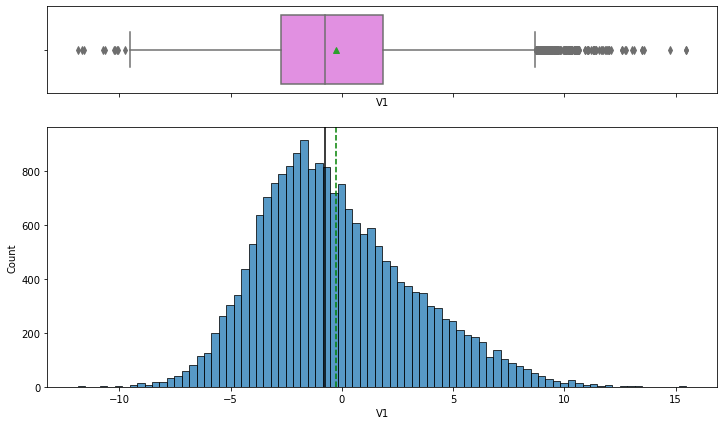

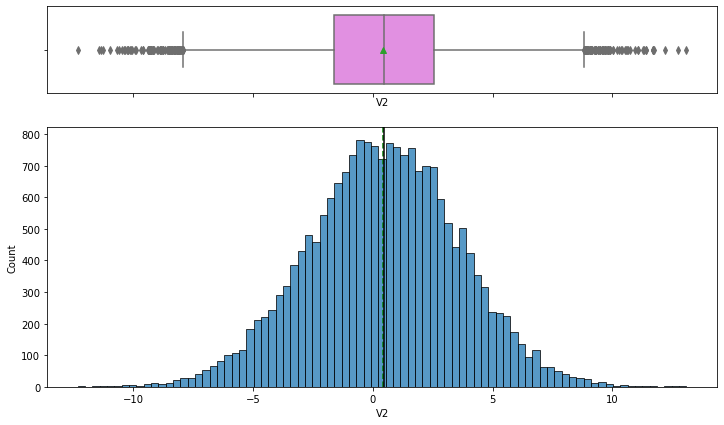

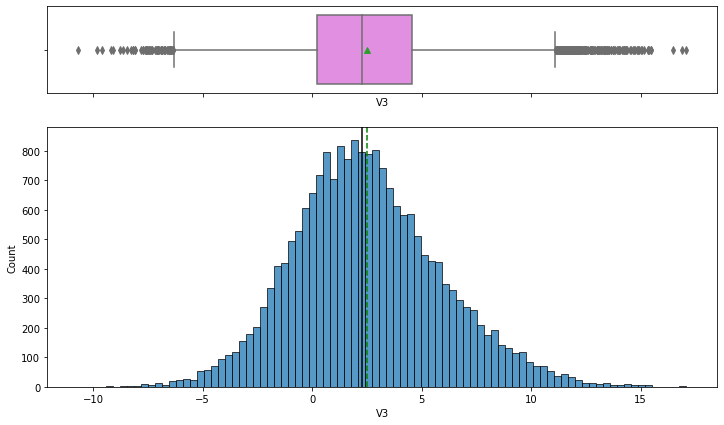

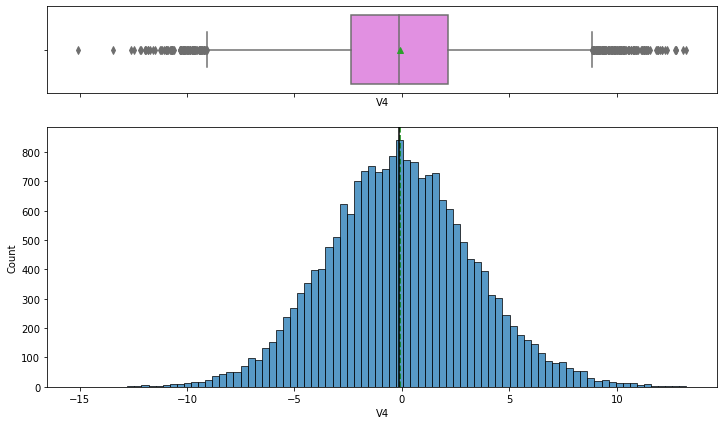

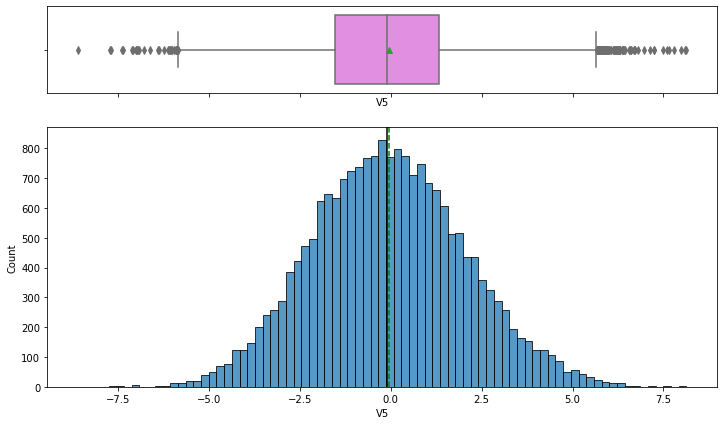

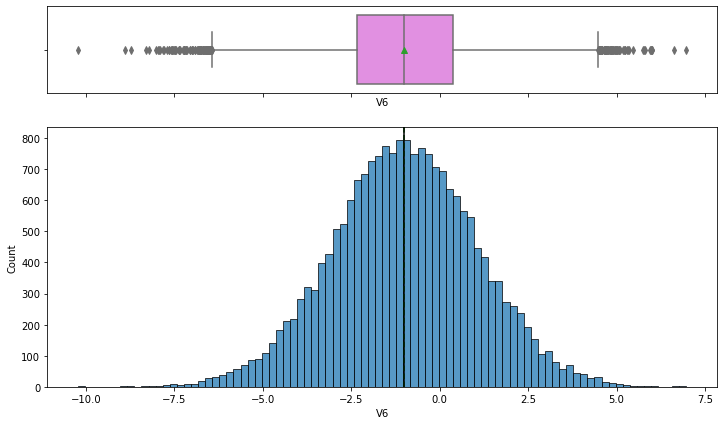

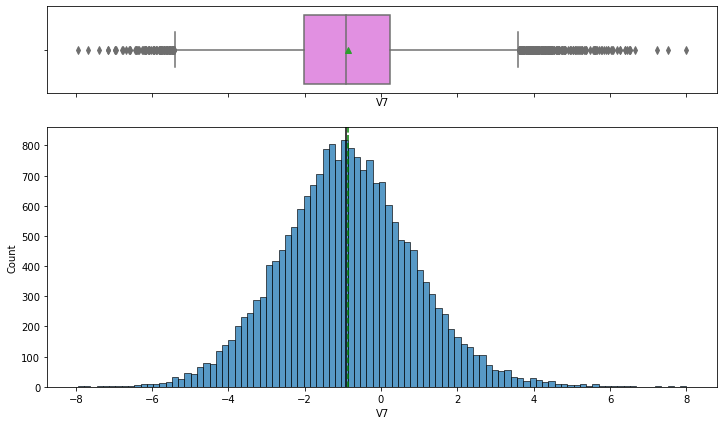

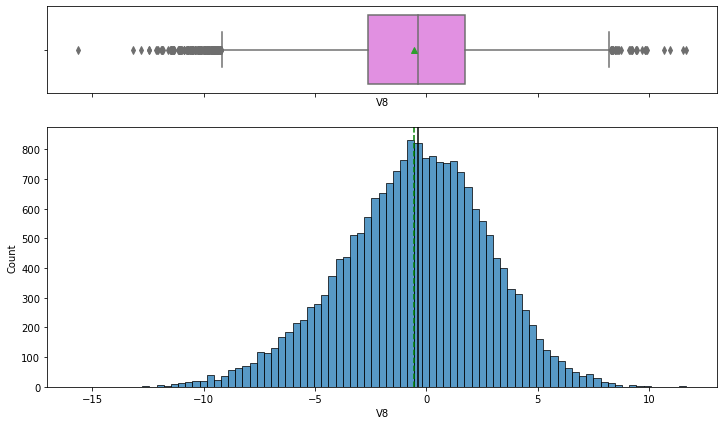

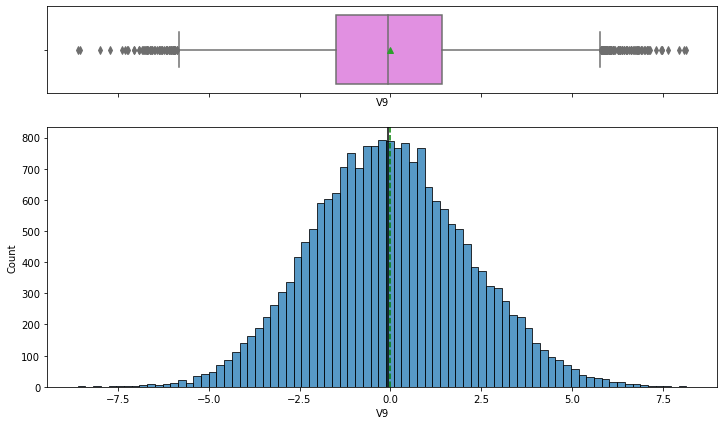

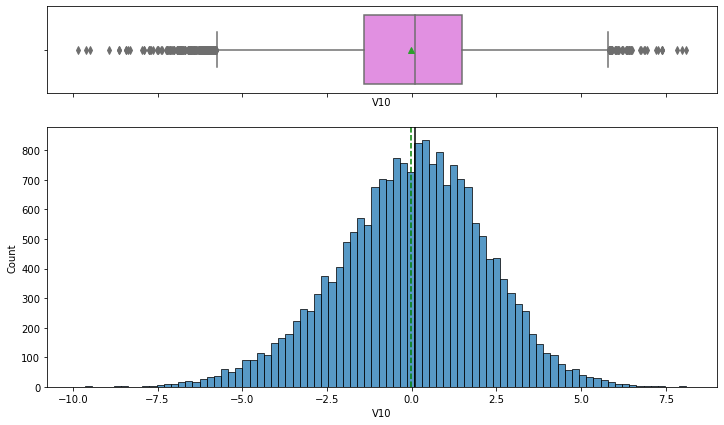

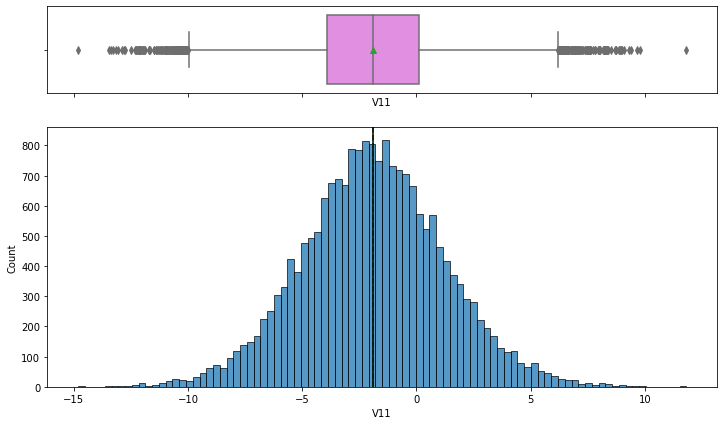

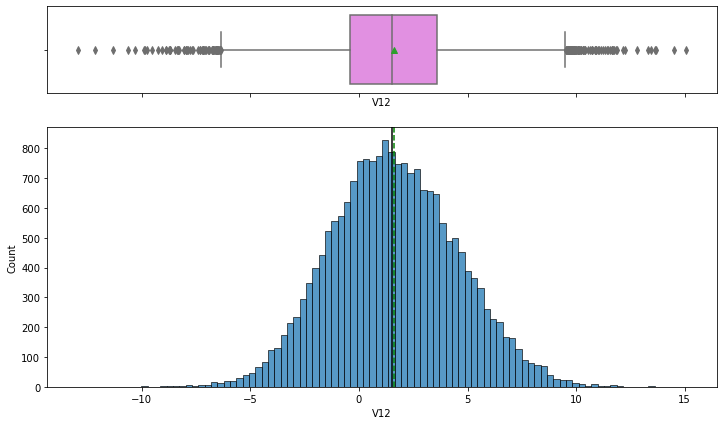

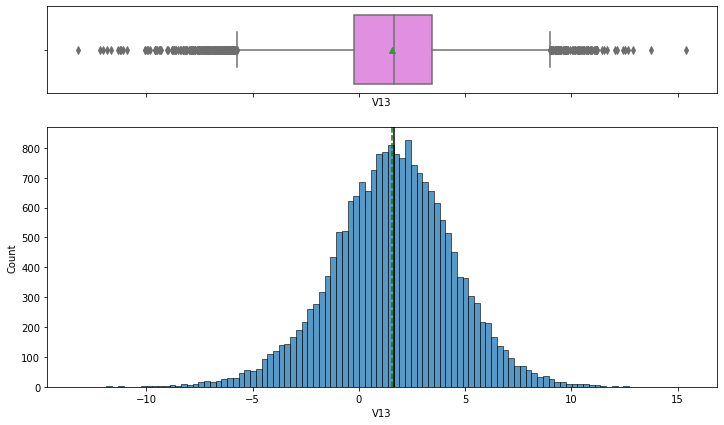

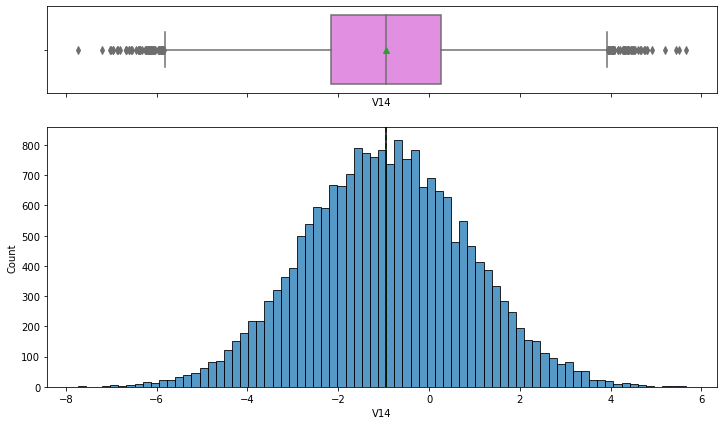

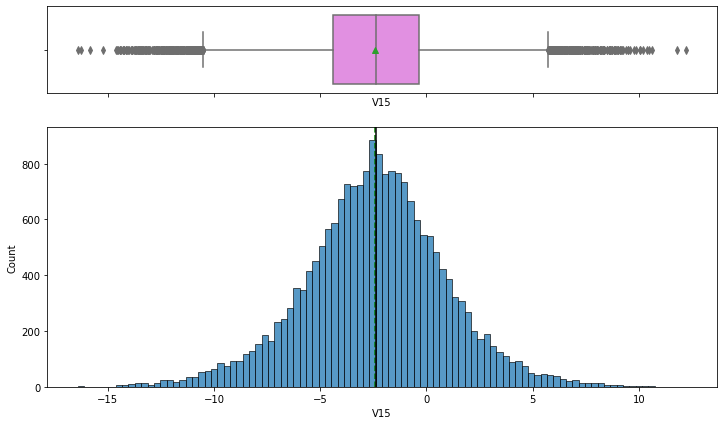

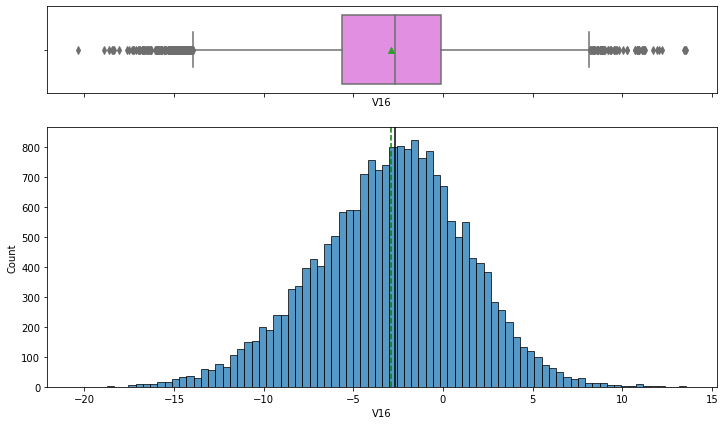

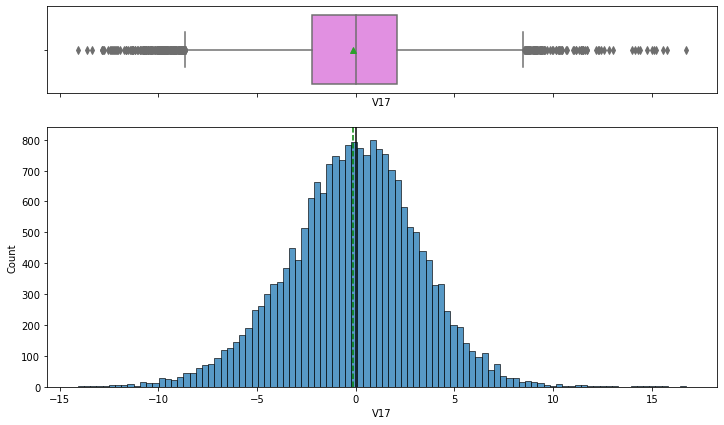

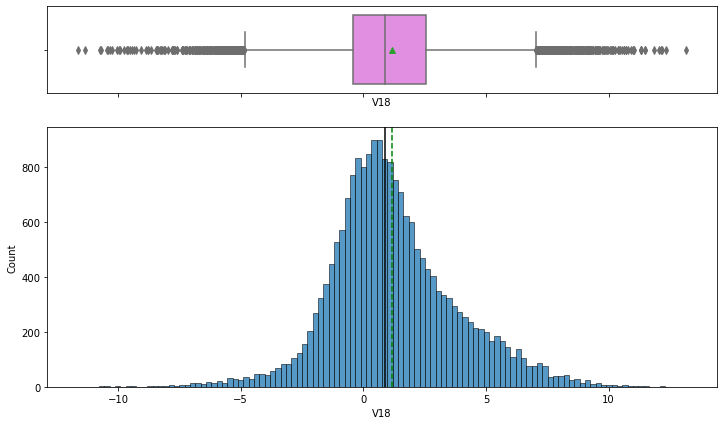

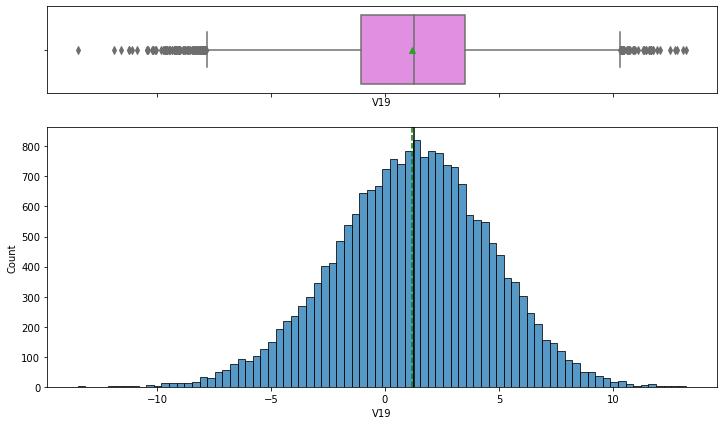

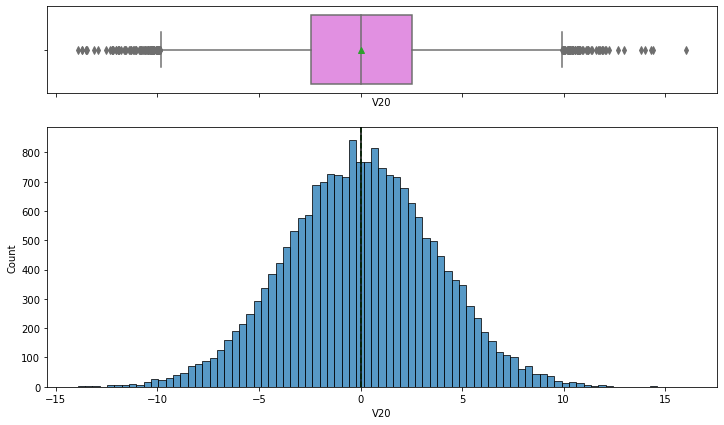

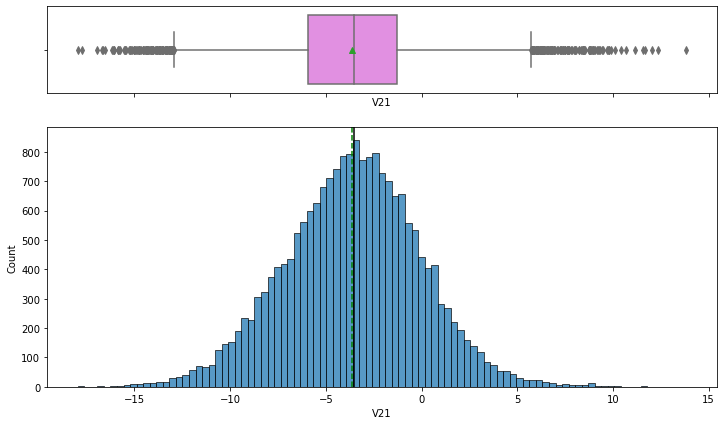

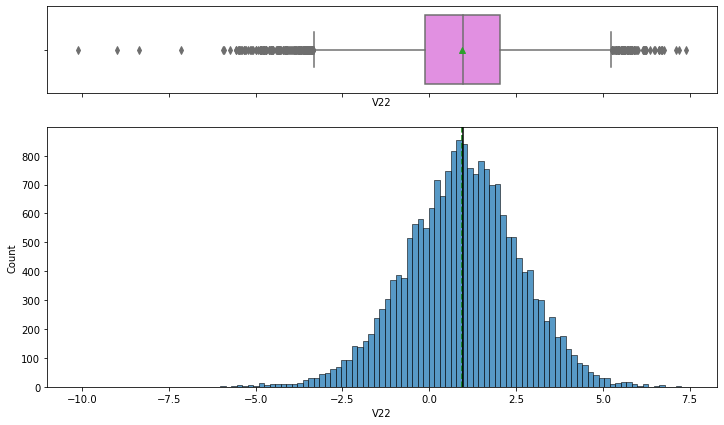

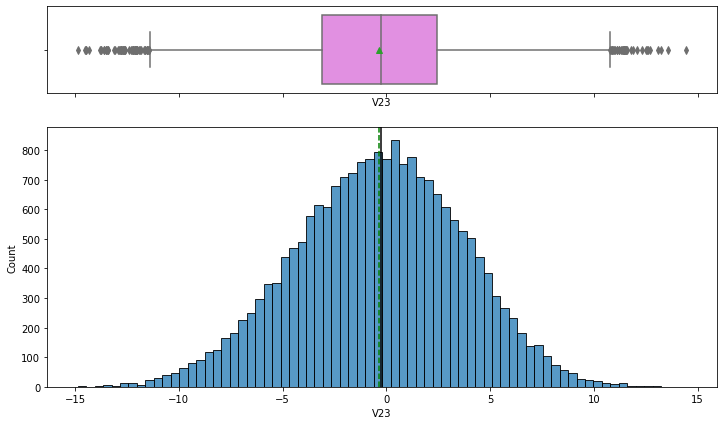

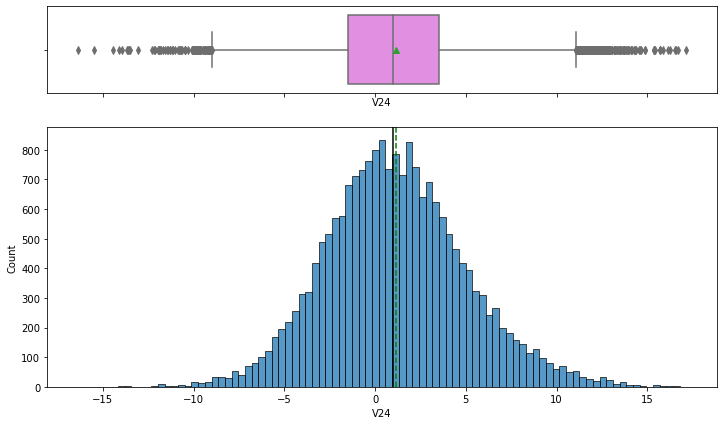

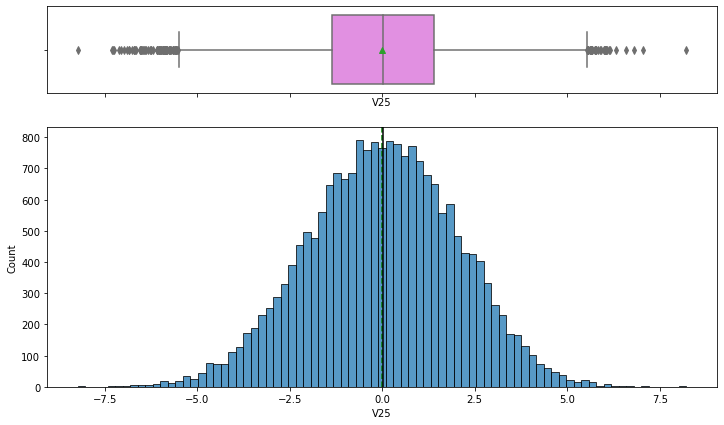

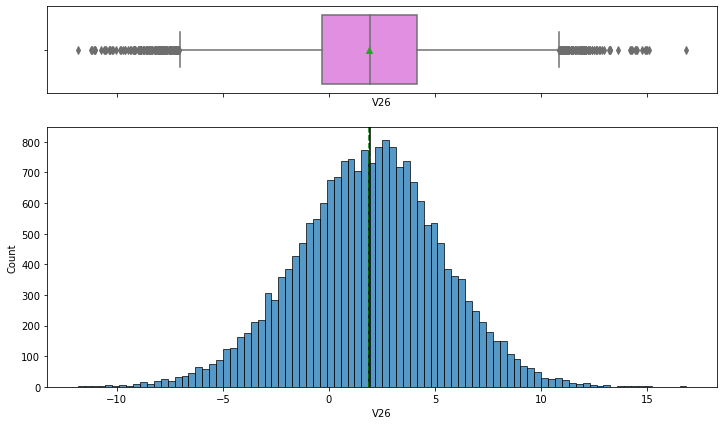

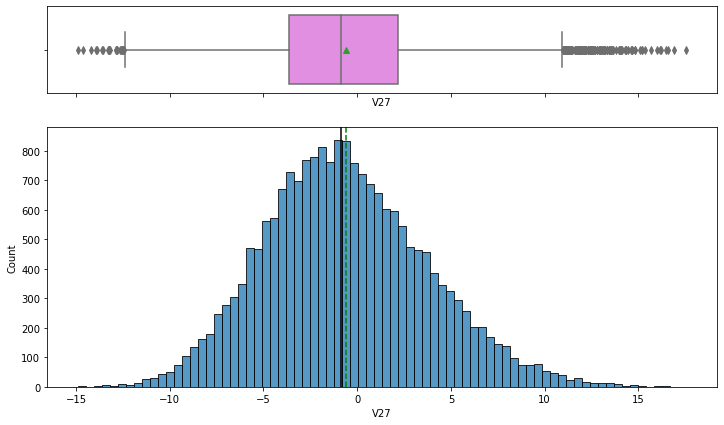

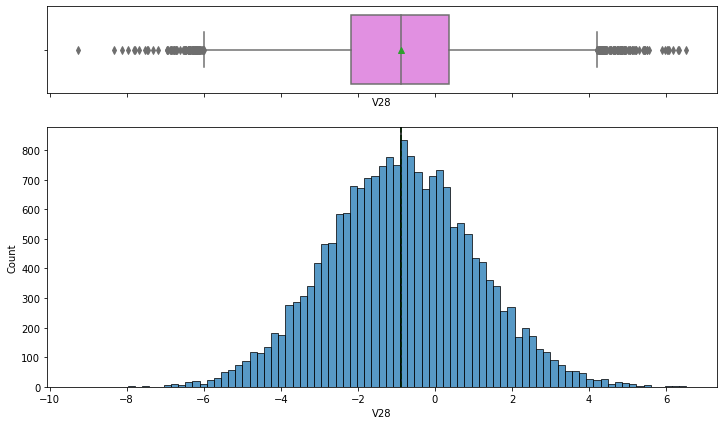

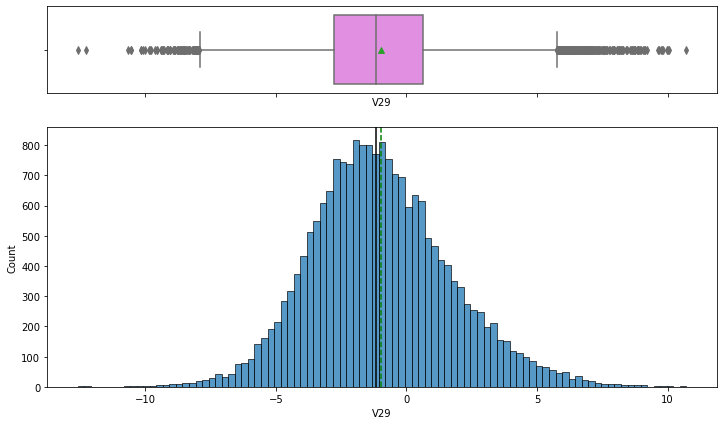

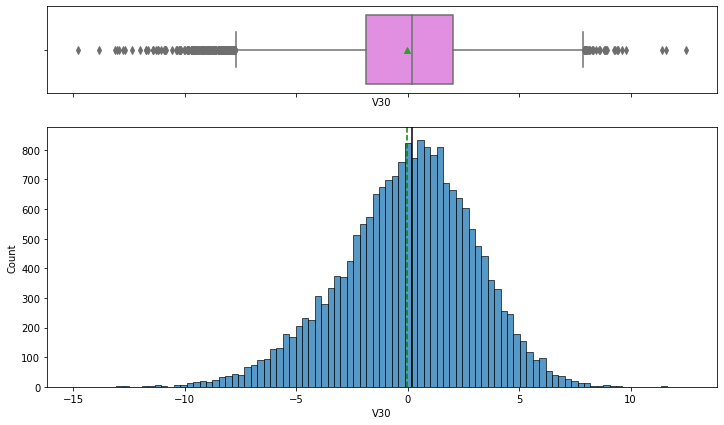

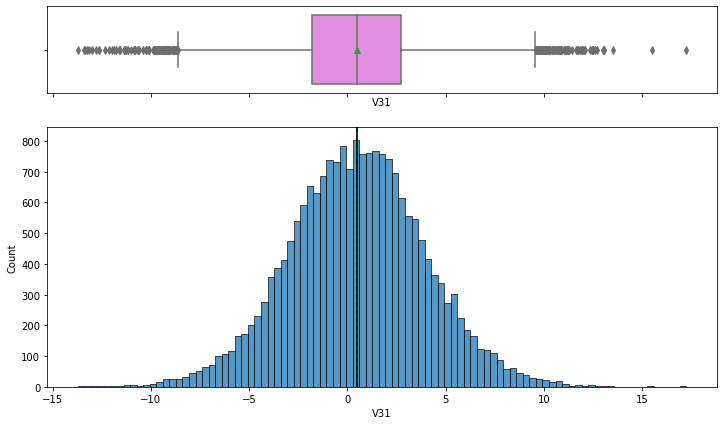

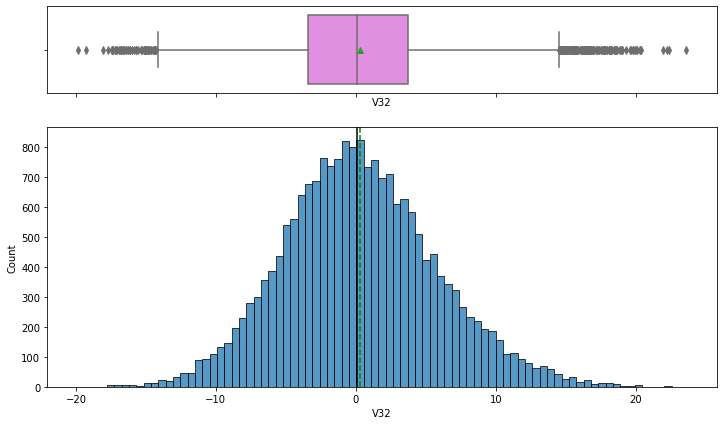

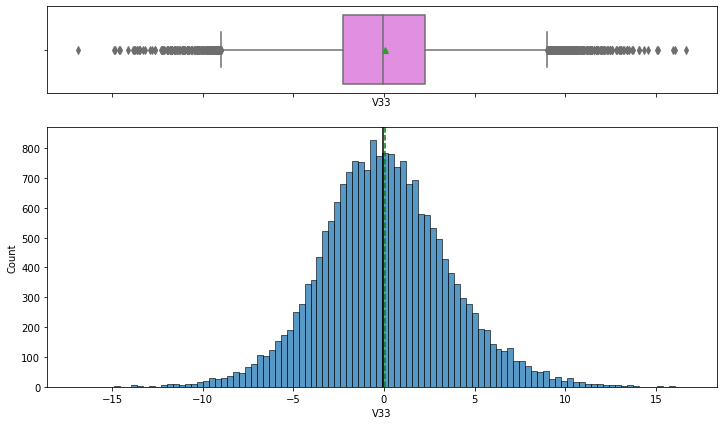

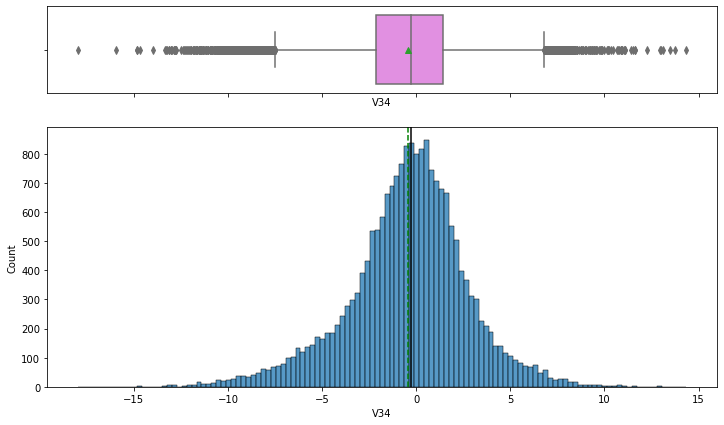

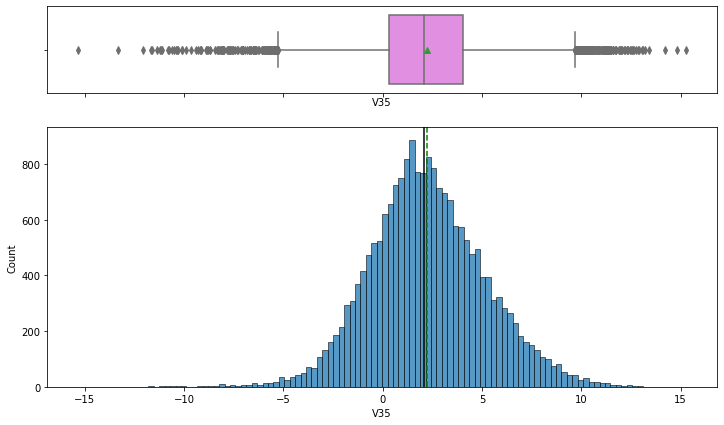

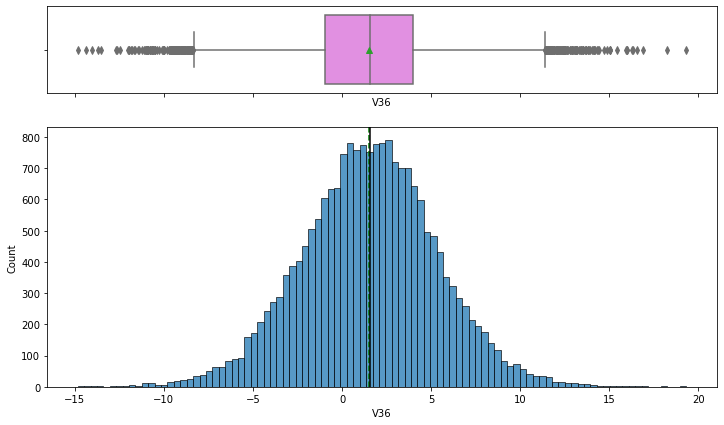

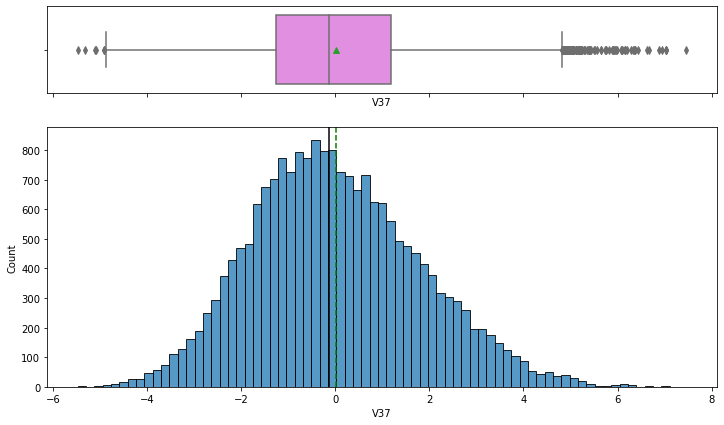

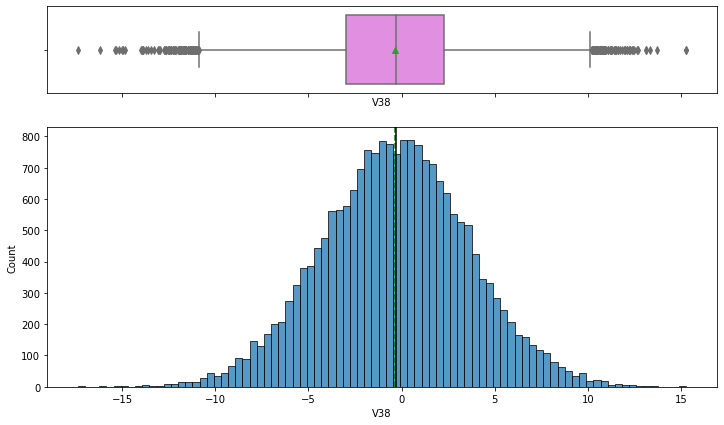

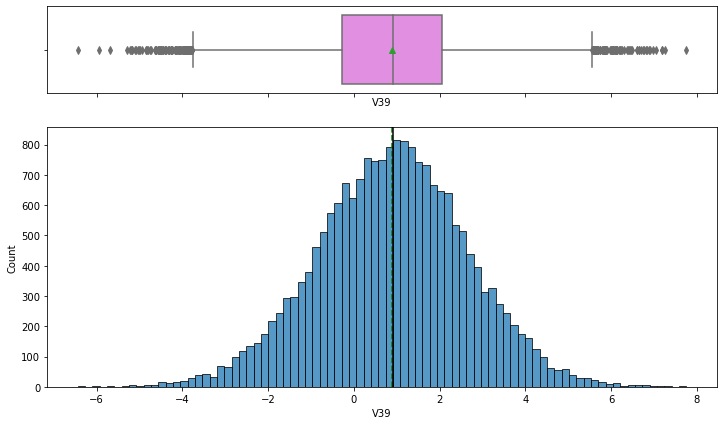

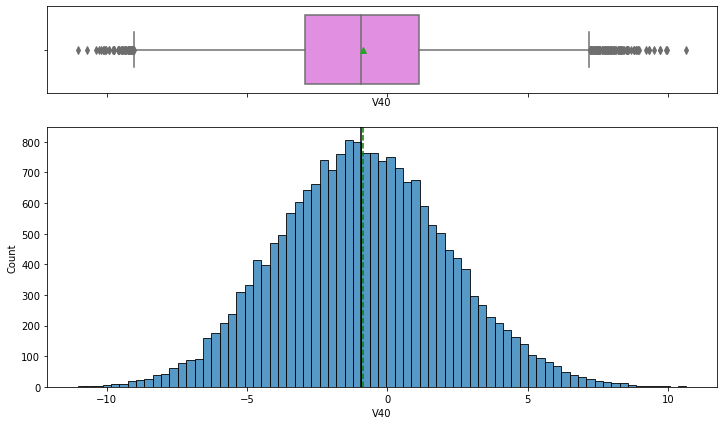

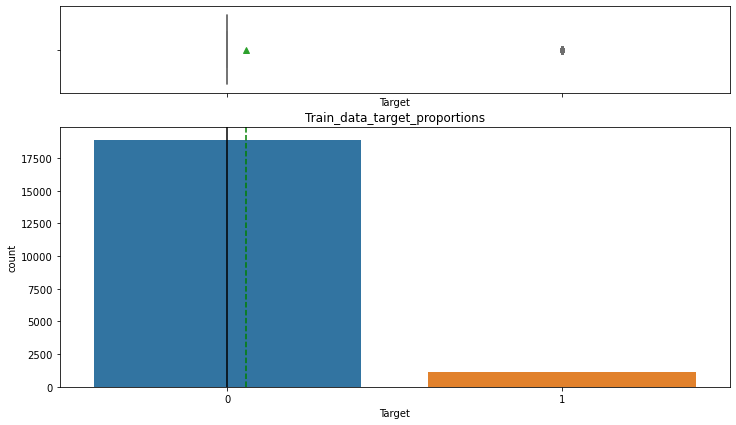

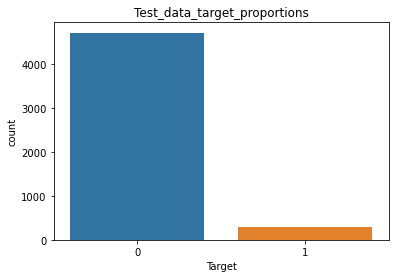

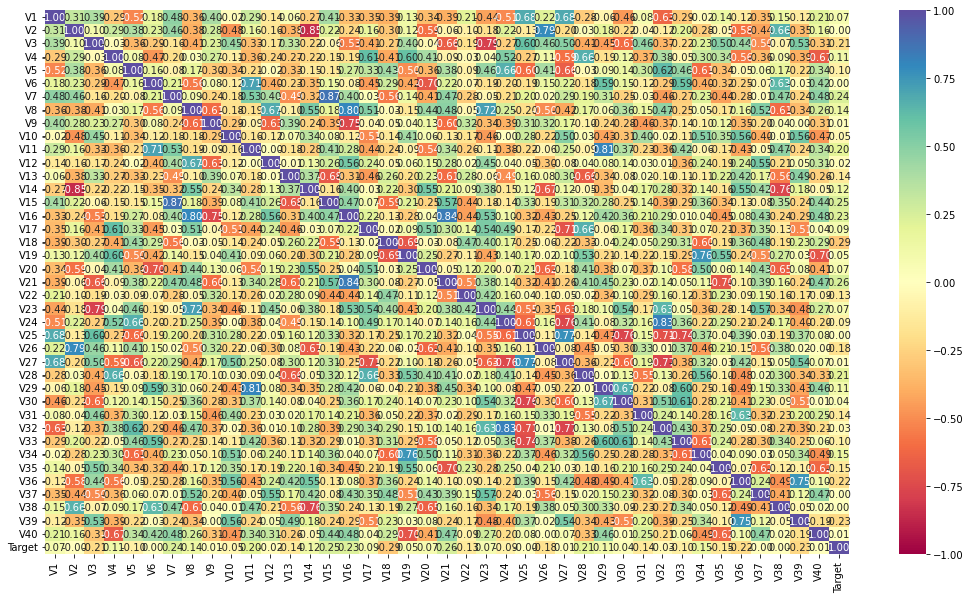

In [6]:
#this function creates histograms and boxplots for each of the columns of data in the dataframe
for feature in df.columns:
    histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None) ## Please change the dataframe name as you define while reading the data
    
#take a look at the proportion of correctly identified faulty turbines in the train and test sets so see if they are similar
sns.countplot(data=data, x='Target')
plt.title('Train_data_target_proportions')
plt.show()

sns.countplot(data=data_test, x='Target')
plt.title('Test_data_target_proportions')
plt.show() 

plt.figure(figsize=(18, 10))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### Observations
- As previously mentioned all variables have outliers but without more knowledge on the specifics of the variables we ca'nt make any adjustments and will not drop any values. 
- All variables are normally distributed.
- The proportion of failed turbines in the test and tain dataframes are approximately the same. 
- We can see that some of the columns do have strong negative and positive correlations but would need unencrypted data to draw conclusions from this.
- None of the 40 predictor variables seems to be particularly positively or negatively correlated with the target variable.
- Due to the encrypted nature of the data we can not complete much further analysis.

## Data Pre-processing

In [7]:
# Dividing train data into X and y 
X= data.drop(['Target'], axis=1)
y= data['Target']

#Split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1, stratify=y)

#make sure the split worked correctly by checking the shape of your newly created dataframes
print(X_train.shape, X_val.shape)

# Divide test data into X_test and y_test
X_test= data_test.drop(['Target'], axis=1)
y_test= data_test['Target']

print(X_test.shape, y_test.shape)

(15000, 40) (5000, 40)
(5000, 40) (5000,)


- These values are all what they should be. Splitting worked as intended

## Missing value imputation




In [8]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Transform the validation data
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_train.columns)
# Transform the test data
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_train.columns)


# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print(X_val.isna().sum())
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V2

- There are now no null values in the training, validation, or testing sets

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [9]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [10]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [11]:
#here we will include all 6 models that we are interested in using to assess turbine failures
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Ada Boost", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boost",  GradientBoostingClassifier(random_state=1)))


results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.6982829521679532
Logistic regression: 0.4927566553639709
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
Ada Boost: 0.6309140754635308
Gradient Boost: 0.7066661857008874

Validation Performance:

dtree: 0.7050359712230215
Logistic regression: 0.48201438848920863
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
Ada Boost: 0.6762589928057554
Gradient Boost: 0.7230215827338129


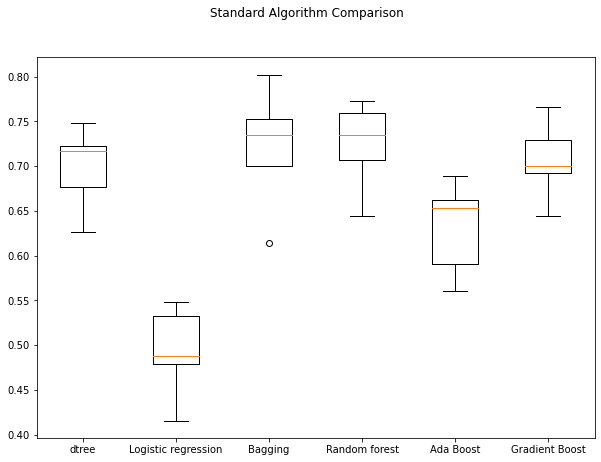

In [12]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Standard Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results1)
ax.set_xticklabels(names)

plt.show()

#### Observations
- Out of the 6 models run on the normal data, the bagging, random forest, and gradiet boosting models performed the best with CV scores between .70-.75 for both train and validation sets
- The difference between the training CV score results and validation CV score results are all similar to one another except for the ada boost model which appeares to be undertrained as the training CV score is .04 below the validation CV score. 

### Model Building with Oversampled data

In [13]:
#print number of failed turbines and working turbiones in the training set before oversampling
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


#print number of failed turbines and working turbiones in the training set after oversampling
print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 832
Before OverSampling, counts of label '0': 14168 

After OverSampling, counts of label '1': 14168
After OverSampling, counts of label '0': 14168 

After OverSampling, the shape of train_X: (28336, 40)
After OverSampling, the shape of train_y: (28336,) 



- After oversampling our data has the same number of failed turbines as turbines that passed the test (14168 turbines). This is what we want with oversampling.

In [14]:
#build models with OVERsampled data
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Ada Boost", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boost",  GradientBoostingClassifier(random_state=1)))


results2 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results2.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.9720494245534969
Logistic regression: 0.883963699328486
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
Ada Boost: 0.8978689011775473
Gradient Boost: 0.9256068151319724

Validation Performance:

dtree: 0.7769784172661871
Logistic regression: 0.8489208633093526
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
Ada Boost: 0.8561151079136691
Gradient Boost: 0.8776978417266187


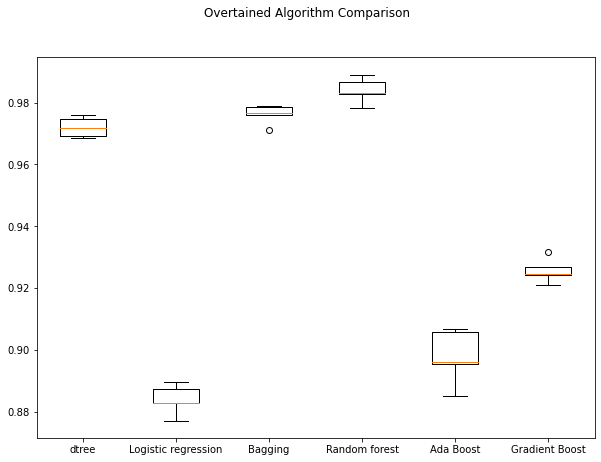

In [15]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Overtained Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results2)
ax.set_xticklabels(names)

plt.show()

#### Observations
- After oversampling the performance increased on training data but the models are now greatly overfit when compared to the validation sets. 
- The bagging and random forest models performed well here just as in the last models, but after oversampling the gradient boosting model is no longer one of the 3 best performing models. The Decision tree model is the 3rd best performing model after the addition of oversampling.
- Although they have lower training and validation scores, the ada boosting model, gradient boosting, and logistic regression are likely the best of these oversampled models as they have the smallest differences between training and validation results.  It's more important that the model can produce repeatable results on new datasets than to have an overfit model that performs well on only one dataset.

### Model Building with Undersampled data

In [16]:
#print number of failed turbines and working turbiones in the training set before undersampling
print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

#print number of failed turbines and working turbiones in the training set after undersampling
print("After UnderSampling, counts of label '1': {}".format(sum(y_train_under == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_under == 0)))

print("After Underampling, the shape of train_X: {}".format(X_train_under.shape))
print("After UnderSampling, the shape of train_y: {} \n".format(y_train_under.shape))

Before UnderSampling, counts of label '1': 832
Before UnderSampling, counts of label '0': 14168 

After UnderSampling, counts of label '1': 832
After UnderSampling, counts of label '0': 832 

After Underampling, the shape of train_X: (1664, 40)
After UnderSampling, the shape of train_y: (1664,) 



- After undersampling our data has thesame number of failed turbines as turbines that passed the test (832 tuurbines). This is what we want.

In [17]:
#build models with UNDERsampled data data
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Ada Boost", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boost",  GradientBoostingClassifier(random_state=1)))


results3 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scorer, cv=kfold
    )
    results3.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_under, y_train_under)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.8617776495202367
Logistic regression: 0.8726138085275232
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
Ada Boost: 0.8666113556020489
Gradient Boost: 0.8990621167303946

Validation Performance:

dtree: 0.841726618705036
Logistic regression: 0.8525179856115108
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
Ada Boost: 0.8489208633093526
Gradient Boost: 0.8884892086330936


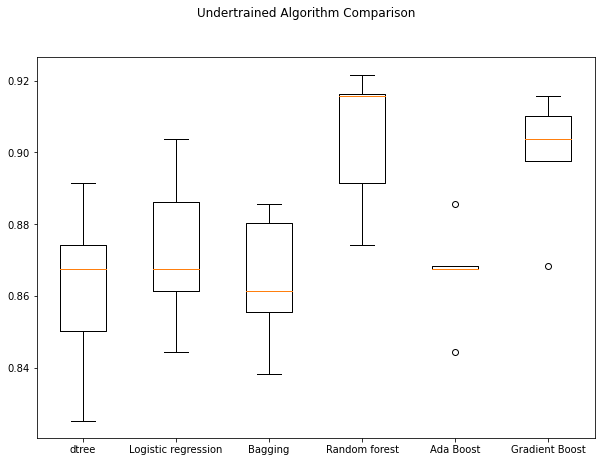

In [18]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Undertrained Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results3)
ax.set_xticklabels(names)

plt.show()

#### Observations
- After undersampling each of our models has a CV score around .80 for for the training and validation data which is a great improvment from the origional models without undersampling. 
- There is minimal underfitting as all training CV scores are within 0.02 of their validation CV scores for each respective model. 
- All of these models performed fairly well however the random forest and gradient models had the best results with minimal overfit.

## HyperparameterTuning 
Certain models performed better on normal data while others performed better on over sampled data and undersampled data. Do to the fact that their was not one clear winner across all sampling methods, I elected to build normal, over sampled, and under sampled models for all six of the model versions listed below. This will take a longer time to compplete but will give use the confidence that we have truely exhausted our options and found the best model available.  

   - Random Forest model
   - Gradient Boost model 
   - Bagging model
   - ADA model
   - Decision tree 
   - Logistic regression model

In [19]:
#create confusion matrix  to measure performance of models
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Tuning methods for Random Forest (Original data)

In [20]:
# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train) ## Complete the code to fit the model on under sampled data

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6996248466921577:


In [21]:
# Creating new pipeline with best parameters
tuned_rf = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.6,
    n_estimators=250,
    min_samples_leaf=1,
)

tuned_rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=250,
                       random_state=1)

In [22]:
#check the performance on train set
rf2_train_orig = model_performance_classification_sklearn(
    tuned_rf, X_train, y_train
)
print("Training performance:")
rf2_train_orig

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.909,1.000,0.952


In [23]:
#check the performance on validation set
rf2_val_orig = model_performance_classification_sklearn(
    tuned_rf, X_val, y_val
)
print("validation performance:")
rf2_val_orig

validation performance:


,Accuracy,Recall,Precision,F1
0,0.983,0.712,0.985,0.827


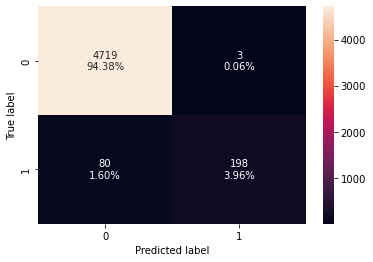

In [24]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf, X_val, y_val)

### Tuning methods for Random Forest (Oversampled data)

In [25]:
#tune random forest with oversampled data

# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9818606498020482:


In [26]:
# Creating new pipeline with best parameters
tuned_rf_over = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.6,
    n_estimators=250,
    min_samples_leaf=1,
)

tuned_rf_over.fit(X_train_over, y_train_over) 

RandomForestClassifier(max_features='sqrt', max_samples=0.6, n_estimators=250,
                       random_state=1)

In [27]:
#check the performance on train set
rf2_train_over = model_performance_classification_sklearn(
    tuned_rf_over, X_train, y_train
)
print("Training performance:")
rf2_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,0.999,0.999


In [28]:
#check the performance on validation set
rf2_val_over = model_performance_classification_sklearn(
    tuned_rf_over, X_val, y_val
)
print("validation performance:")
rf2_val_over

validation performance:


,Accuracy,Recall,Precision,F1
0,0.988,0.863,0.920,0.891


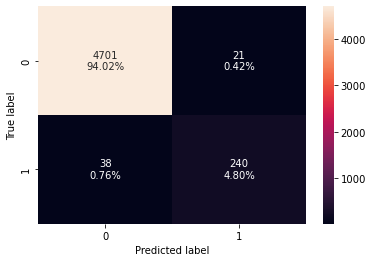

In [29]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf_over, X_val, y_val)

### Tuning methods for Random Forest (Undersampled data)

In [30]:
#tune random forest with undersampled data


# defining model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under, y_train_under) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} with CV score=0.8990116153235697:


In [31]:
# Creating new pipeline with best parameters
tuned_rf_under = RandomForestClassifier(
    max_features='sqrt',
    random_state=1,
    max_samples=0.5,
    n_estimators=300,
    min_samples_leaf=2,
)

tuned_rf_under.fit(X_train_under, y_train_under) 

RandomForestClassifier(max_features='sqrt', max_samples=0.5, min_samples_leaf=2,
                       n_estimators=300, random_state=1)

In [32]:
#check the performance on train set
rf2_train_under = model_performance_classification_sklearn(
    tuned_rf_under, X_train, y_train
)
print("Training performance:")
rf2_train_under

Training performance:


,Accuracy,Recall,Precision,F1
0,0.947,0.933,0.513,0.662


In [33]:
#check the performance on validation set
rf2_val_under = model_performance_classification_sklearn(
    tuned_rf_under, X_val, y_val
)
print("validation performance:")
rf2_val_under

validation performance:


,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.468,0.612


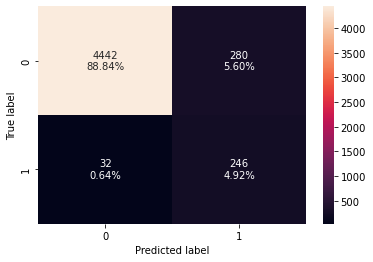

In [34]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_rf_under, X_val, y_val)

#### Observations (Random forest models)
- The normal data and oversampled data versions of these models are overfit for recall while the undersampled model has only approx .05 difference between train and validation models. 

- It is the most important to minimize recall as we want to minimize false negatives and same renewind money so the undersampled model would be best of the random forest models.

### Tuning methods for Gradient Boost (Original data)

In [35]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7536902099415628:


In [36]:
# Creating new pipeline with best parameters
tuned_gb = GradientBoostingClassifier(
    max_features=0.5,
    subsample= 0.7,
    n_estimators=125,
    learning_rate= 0.2,
)

tuned_gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, subsample=0.7)

In [37]:
#check the performance on train set
gb_train_orig = model_performance_classification_sklearn(
    tuned_gb, X_train, y_train
)
print("Training performance:")
gb_train_orig

Training performance:


,Accuracy,Recall,Precision,F1
0,0.992,0.869,0.986,0.924


In [38]:
#check the performance on validation set
gb_val_orig = model_performance_classification_sklearn(
    tuned_gb, X_val, y_val
)
print("validation performance:")
gb_val_orig

validation performance:


,Accuracy,Recall,Precision,F1
0,0.984,0.763,0.930,0.838


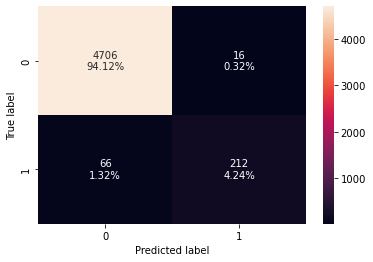

In [39]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_gb, X_val, y_val)

### Tuning methods for Gradient Boost (Oversampled data)

In [40]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9726851919894598:


In [41]:
# Creating new pipeline with best parameters
tuned_gb_over = GradientBoostingClassifier(
    max_features=0.5,
    subsample= 0.7,
    n_estimators=125,
    learning_rate= 1,
)

tuned_gb_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           subsample=0.7)

In [42]:
#check the performance on train set
gb_train_over = model_performance_classification_sklearn(
    tuned_gb_over, X_train, y_train
)
print("Training performance:")
gb_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.995,0.921,0.957


In [43]:
#check the performance on validation set
gb_val_over = model_performance_classification_sklearn(
    tuned_gb_over, X_val, y_val
)
print("validation performance:")
gb_val_over

validation performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.849,0.654,0.739


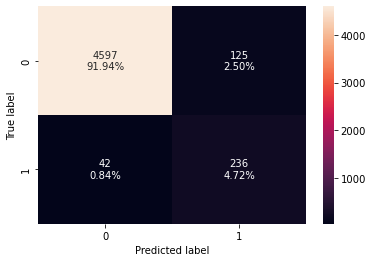

In [44]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_gb_over, X_val, y_val)

### Tuning methods for Gradient Boost (Undersampled data)

In [45]:
# defining model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under, y_train_under) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2} with CV score=0.9038236779453142:


In [46]:
# Creating new pipeline with best parameters
tuned_gb_under = GradientBoostingClassifier(
    max_features=0.7,
    subsample= 0.5,
    n_estimators=125,
    learning_rate= 0.2,
)

tuned_gb_under.fit(X_train_under, y_train_under)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.7,
                           n_estimators=125, subsample=0.5)

In [47]:
#check the performance on train set
gb_train_under = model_performance_classification_sklearn(
    tuned_gb_under, X_train, y_train
)
print("Training performance:")
gb_train_under

Training performance:


,Accuracy,Recall,Precision,F1
0,0.930,0.989,0.442,0.611


In [48]:
#check the performance on validation set
gb_val_under = model_performance_classification_sklearn(
    tuned_gb_under, X_val, y_val
)
print("validation performance:")
gb_val_under

validation performance:


,Accuracy,Recall,Precision,F1
0,0.918,0.881,0.395,0.546


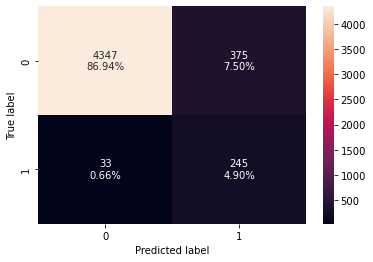

In [49]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_gb_under, X_val, y_val)

#### Observations (Gradient Boost models)
- All three gradient boost models show overfit between train and validation data results. Because of this, none of these models should be used in production. 

### Tuning methods for Bagging Model (Original data)

In [50]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.9} with CV score=0.7320395353870571:


In [51]:
# Creating new pipeline with best parameters
tuned_boost = BaggingClassifier(
    max_samples=0.9,
    max_features= 0.9,
    n_estimators=50,
)

tuned_boost.fit(X_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=50)

In [52]:
#check the performance on train set
boost_train_orig = model_performance_classification_sklearn(
    tuned_boost, X_train, y_train
)
print("Training performance:")
boost_train_orig

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,0.993,1.000,0.996


In [53]:
#check the performance on validation set
boost_val_orig = model_performance_classification_sklearn(
    tuned_boost, X_val, y_val
)
print("validation performance:")
boost_val_orig

validation performance:


,Accuracy,Recall,Precision,F1
0,0.983,0.730,0.958,0.829


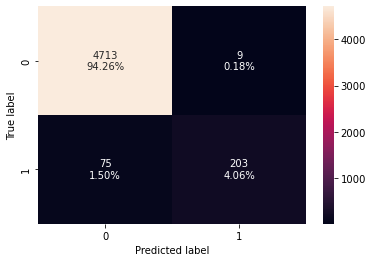

In [54]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_boost, X_val, y_val)

### Tuning methods for Bagging Model (Over sampled)

In [55]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.9828488269988673:


In [56]:
# Creating new pipeline with best parameters
tuned_boost_over = BaggingClassifier(
    max_samples=0.9,
    max_features= 0.8,
    n_estimators=70,
)

tuned_boost_over.fit(X_train_over, y_train_over)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=70)

In [57]:
#check the performance on train set
boost_train_over = model_performance_classification_sklearn(
    tuned_boost_over, X_train, y_train
)
print("Training performance:")
boost_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


In [58]:
#check the performance on validation set
boost_val_over = model_performance_classification_sklearn(
    tuned_boost_over, X_val, y_val
)
print("validation performance:")
boost_val_over

validation performance:


,Accuracy,Recall,Precision,F1
0,0.986,0.867,0.880,0.873


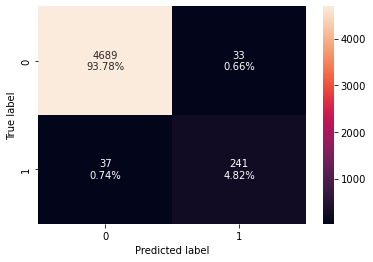

In [59]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_boost_over, X_val, y_val)

### Tuning methods for Bagging Model (Under sampled)

In [60]:
# defining model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under, y_train_under) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 70, 'max_samples': 0.9, 'max_features': 0.9} with CV score=0.8966236202294207:


In [61]:
# Creating new pipeline with best parameters
tuned_boost_under = BaggingClassifier(
    max_samples=0.9,
    max_features= 0.9,
    n_estimators=70,
)

tuned_boost_under.fit(X_train_under, y_train_under)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=70)

In [62]:
#check the performance on train set
boost_train_under = model_performance_classification_sklearn(
    tuned_boost_under, X_train, y_train
)
print("Training performance:")
boost_train_under

Training performance:


,Accuracy,Recall,Precision,F1
0,0.948,0.999,0.517,0.681


In [63]:
#check the performance on validation set
boost_val_under = model_performance_classification_sklearn(
    tuned_boost_under, X_val, y_val
)
print("validation performance:")
boost_val_under

validation performance:


,Accuracy,Recall,Precision,F1
0,0.932,0.888,0.445,0.593


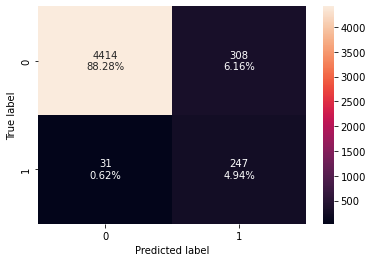

In [64]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_boost_under, X_val, y_val)

#### Observations (Bagging models)
- All three Bagging boost models show overfit between train and validation data results. Because of this, none of these models should be used in production. 

### AdaBoost model tuning (normal data)

In [65]:
# defining model (Adaboost)
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train) 

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.762051800014429:


In [66]:
# Creating new pipeline with best parameters
tuned_adaboost = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=2, random_state=1),
    learning_rate= 0.05,
    n_estimators=200,
)

tuned_adaboost.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.05, n_estimators=200)

In [67]:
#check the performance on train set
adaboost_train_orig = model_performance_classification_sklearn(
    tuned_adaboost, X_train, y_train
)
print("Training performance:")
adaboost_train_orig

Training performance:


,Accuracy,Recall,Precision,F1
0,0.981,0.673,0.986,0.800


In [68]:
#check the performance on validation set
adaboost_val_orig = model_performance_classification_sklearn(
    tuned_adaboost, X_val, y_val
)
print("validation performance:")
adaboost_val_orig

validation performance:


,Accuracy,Recall,Precision,F1
0,0.979,0.647,0.973,0.778


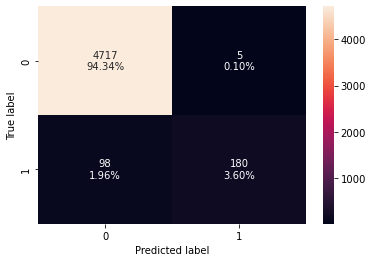

In [69]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_adaboost, X_val, y_val)

### AdaBoost model tuning (Oversampled data)

In [70]:
# defining model (Adaboost)
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9715559462639259:


In [71]:
# Creating new pipeline with best parameters
tuned_adaboost_over = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=3, random_state=1),
    learning_rate= 0.2,
    n_estimators=200,
)

tuned_adaboost_over.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200)

In [72]:
#check the performance on train set
adaboost_train_over = model_performance_classification_sklearn(
    tuned_adaboost_over, X_train, y_train
)
print("Training performance:")
adaboost_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.993,0.925,0.958


In [73]:
#check the performance on val set
adaboost_val_over = model_performance_classification_sklearn(
    tuned_adaboost_over, X_val, y_val
)
print("validation performance:")
adaboost_val_over

validation performance:


,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


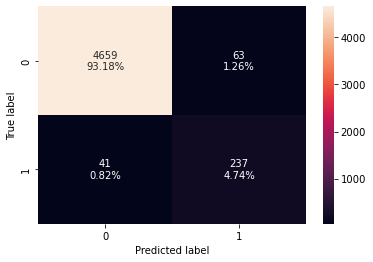

In [74]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_adaboost_over, X_val, y_val)

### AdaBoost model tuning (Undersampled data)

In [75]:
# defining model (Adaboost)
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under, y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.05, 'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1)} with CV score=0.8906283817906356:


In [76]:
# Creating new pipeline with best parameters
tuned_adaboost_under = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=2, random_state=1),
    learning_rate= 0.05,
    n_estimators=200,
)

tuned_adaboost_under.fit(X_train_under, y_train_under)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.05, n_estimators=200)

In [77]:
#check the performance on train set
adaboost_train_under = model_performance_classification_sklearn(
    tuned_adaboost_under, X_train, y_train
)
print("Training performance:")
adaboost_train_under

Training performance:


,Accuracy,Recall,Precision,F1
0,0.935,0.916,0.458,0.610


In [78]:
#check the performance on val set
adaboost_val_under = model_performance_classification_sklearn(
    tuned_adaboost_under, X_val, y_val
)
print("validation performance:")
adaboost_val_under

validation performance:


,Accuracy,Recall,Precision,F1
0,0.926,0.874,0.420,0.567


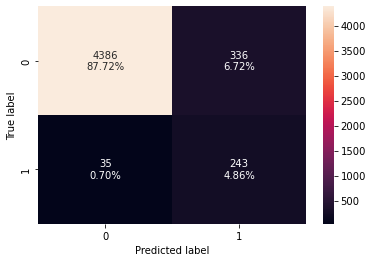

In [79]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_adaboost_under, X_val, y_val)

#### Observations (AdaBoost models)
- While the normal model and undersampled model both showed little over/underfit but the underfit model had far superior performance with scores betwen 0.87 and 0.91
- The oversampled model showed significant overfit and should not be used in production.

### Decision Tree tuning (Original data)

In [80]:
# defining model (Decision tree)
Model = DecisionTreeClassifier(random_state=1)
 
# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 15, 'max_depth': 5} with CV score=0.5756511074237067:


In [81]:
# Creating new pipeline with best parameters
tuned_dtree_orig = DecisionTreeClassifier(
    min_samples_leaf= 1,
    min_impurity_decrease= 0.0001, 
    max_leaf_nodes= 15, 
    max_depth= 5
)

tuned_dtree_orig.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=15,
                       min_impurity_decrease=0.0001)

In [82]:
#check the performance on train set
dtree_train_orig = model_performance_classification_sklearn(
    tuned_dtree_orig, X_train, y_train
)
print("Training performance:")
dtree_train_orig

Training performance:


,Accuracy,Recall,Precision,F1
0,0.974,0.584,0.914,0.713


In [83]:
#check the performance on validation set
dtree_val_orig = model_performance_classification_sklearn(
    tuned_dtree_orig, X_val, y_val
)
print("Validation performance:")
dtree_val_orig

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.970,0.568,0.832,0.675


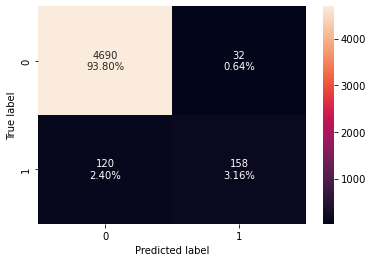

In [84]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_dtree_orig, X_val, y_val)

### Decision Tree tuning (Oversampled data)

In [85]:
# defining model (Decision tree)
Model = DecisionTreeClassifier(random_state=1)
 
# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 10, 'max_depth': 3} with CV score=0.9102913265648006:


In [86]:
# Creating new pipeline with best parameters
tuned_dtree_over = DecisionTreeClassifier(
    min_samples_leaf= 1,
    min_impurity_decrease= 0.0001, 
    max_leaf_nodes= 10, 
    max_depth= 3
)

tuned_dtree_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10,
                       min_impurity_decrease=0.0001)

In [87]:
#check the performance on train set
dtree_train_over = model_performance_classification_sklearn(
    tuned_dtree_over, X_train, y_train
)
print("Training performance:")
dtree_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,0.776,0.898,0.186,0.308


In [88]:
#check the performance on validation set
dtree_val_over = model_performance_classification_sklearn(
    tuned_dtree_over, X_val, y_val
)
print("validation performance:")
dtree_val_over

validation performance:


,Accuracy,Recall,Precision,F1
0,0.763,0.885,0.176,0.294


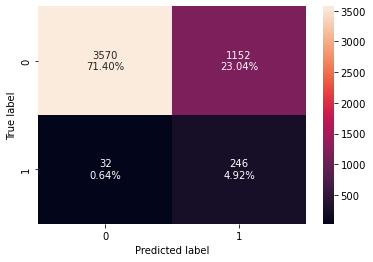

In [89]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_dtree_over, X_val, y_val)

### Decision Tree tuning  (Undersampled data)

In [90]:
# defining model (Decision tree)
Model = DecisionTreeClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under, y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'min_samples_leaf': 1, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 10, 'max_depth': 2} with CV score=0.850811629752543:


In [91]:
# Creating new pipeline with best parameters
tuned_dtree_under = DecisionTreeClassifier(
    min_samples_leaf= 1,
    min_impurity_decrease= 0.0001, 
    max_leaf_nodes= 10, 
    max_depth= 2
)

tuned_dtree_under.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=10,
                       min_impurity_decrease=0.0001)

In [92]:
#check the performance on train set
dtree_train_under = model_performance_classification_sklearn(
    tuned_dtree_under, X_train, y_train
)
print("Training performance:")
dtree_train_under

Training performance:


,Accuracy,Recall,Precision,F1
0,0.624,0.909,0.120,0.211


In [93]:
#check the performance on validation set
dtree_val_under = model_performance_classification_sklearn(
    tuned_dtree_under, X_val, y_val
)
print("validation performance:")
dtree_val_under

validation performance:


,Accuracy,Recall,Precision,F1
0,0.609,0.888,0.114,0.202


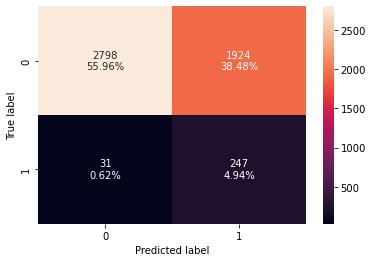

In [94]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_dtree_under, X_val, y_val)

#### Observations (Decision Tree models)
- All three model have minimal overfit and both over and underfit models have recall scores in the high .8s. With that being said their accuracy, precision and F1 scores as very low for all models. these are likely not googd choices for the final model


### Logistic Regression tuning (Original data)

In [95]:
# defining model (LogisticRegression)
Model = LogisticRegression(random_state=1)
 
# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.2} with CV score=0.4952240098117019:


In [96]:
# Creating new pipeline with best parameters
tuned_logreg_orig = LogisticRegression(
     C = 0.2
)

tuned_logreg_orig.fit(X_train, y_train)

LogisticRegression(C=0.2)

In [97]:
#check the performance on train set
logreg_train_orig = model_performance_classification_sklearn(
    tuned_logreg_orig, X_train, y_train
)
print("Training performance:")
logreg_train_orig

Training performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.495,0.844,0.624


In [98]:
#check the performance on validation set
logreg_val_orig = model_performance_classification_sklearn(
    tuned_logreg_orig, X_val, y_val
)
print("Validation performance:")
logreg_val_orig

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.966,0.482,0.843,0.613


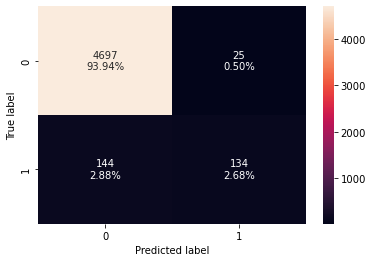

In [99]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_logreg_orig, X_val, y_val)

### Logistic Regression tuning (Oversampled data)

In [100]:
# defining model (LogisticRegression)
Model = LogisticRegression(random_state=1)
 
# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8838231041005031:


In [101]:
# Creating new pipeline with best parameters
tuned_logreg_over = LogisticRegression(
     C = 0.1
)

tuned_logreg_over.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [102]:
#check the performance on train set
logreg_train_over = model_performance_classification_sklearn(
    tuned_logreg_over, X_train, y_train
)
print("Training performance:")
logreg_train_over

Training performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.495,0.846,0.625


In [103]:
#check the performance on validation set
logreg_val_over = model_performance_classification_sklearn(
    tuned_logreg_over, X_val, y_val
)
print("Validation performance:")
logreg_val_over

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.966,0.482,0.843,0.613


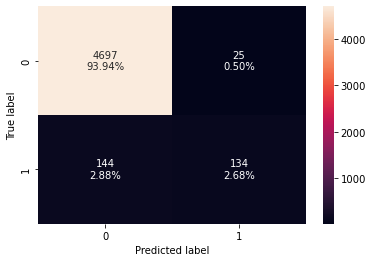

In [104]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_logreg_over, X_val, y_val)

### Logistic Regression tuning (Undersampled data)

In [105]:
# defining model (LogisticRegression)
Model = LogisticRegression(random_state=1)
 
# Parameter grid to pass in RandomSearchCV
param_grid = {'C': np.arange(0.1,1.1,0.1)}

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under, y_train_under)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'C': 0.1} with CV score=0.8653560349181155:


In [106]:
# Creating new pipeline with best parameters
tuned_logreg_under = LogisticRegression(
     C = 0.1
)

tuned_logreg_under.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [107]:
#check the performance on train set
logreg_train_under = model_performance_classification_sklearn(
    tuned_logreg_under, X_train, y_train
)
print("Training performance:")
logreg_train_under

Training performance:


,Accuracy,Recall,Precision,F1
0,0.967,0.495,0.846,0.625


In [108]:
#check the performance on validation set
logreg_val_under = model_performance_classification_sklearn(
    tuned_logreg_under, X_val, y_val
)
print("Validation performance:")
logreg_val_under

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.966,0.482,0.843,0.613


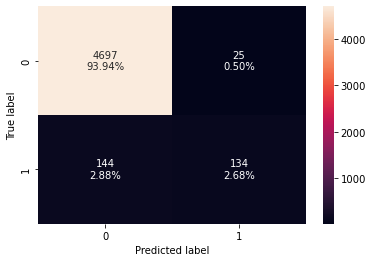

In [109]:
# creating confusion matrix
confusion_matrix_sklearn(tuned_logreg_under, X_val, y_val)

#### Observations (Logisitc regression models)
- All three models are exactly the same here as the random search selected the same hyperparameters for all three datasets.
- The recall scores are low and therefore these models arent a good option for production

## Model performance comparison and choosing the final model

In [110]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        rf2_train_orig.T,
        rf2_train_over.T,
        rf2_train_under.T,
        gb_train_orig.T,
        gb_train_over.T,
        gb_train_under.T,
        boost_train_orig.T,
        boost_train_over.T,
        boost_train_under.T,
        adaboost_train_orig.T,
        adaboost_train_over.T,
        adaboost_train_under.T,
        dtree_train_orig.T,
        dtree_train_over.T,
        dtree_train_under.T,
        logreg_train_orig.T,
        logreg_train_over.T,
        logreg_train_under.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random forest tuned with normal data",
    "Random forest tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient boosting tuned with normal data",
    "Gradient boosting tuned with oversampled data",
    "Gradient boosting tuned with undersampled data",
    "Bagging model tuned with normal data",
    "Bagging model tuned with oversampled data",
    "Bagging model tuned with undersampled data",
    "AdaBoost model tuned with normal data",
    "AdaBoost model tuned with oversampled data",
    "AdaBoost model tuned with undersampled data",
    "Decision tree model tuned with normal data",
    "Decision tree tuned with oversampled data",
    "Decision tree tuned with undersampled data",
    "Logistic Regression model tuned with normal data",
    "Logistic Regression tuned with oversampled data",
    "Logistic Regression tuned with undersampled data",
 
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Random forest tuned with normal data,Random forest tuned with oversampled data,Random forest tuned with undersampled data,Gradient boosting tuned with normal data,Gradient boosting tuned with oversampled data,Gradient boosting tuned with undersampled data,Bagging model tuned with normal data,Bagging model tuned with oversampled data,Bagging model tuned with undersampled data,AdaBoost model tuned with normal data,AdaBoost model tuned with oversampled data,AdaBoost model tuned with undersampled data,Decision tree model tuned with normal data,Decision tree tuned with oversampled data,Decision tree tuned with undersampled data,Logistic Regression model tuned with normal data,Logistic Regression tuned with oversampled data,Logistic Regression tuned with undersampled data
Accuracy,0.995,1.000,0.947,0.992,0.995,0.930,1.000,1.000,0.948,0.981,0.995,0.935,0.974,0.776,0.624,0.967,0.967,0.967
Recall,0.909,1.000,0.933,0.869,0.995,0.989,0.993,1.000,0.999,0.673,0.993,0.916,0.584,0.898,0.909,0.495,0.495,0.495
Precision,1.000,0.999,0.513,0.986,0.921,0.442,1.000,1.000,0.517,0.986,0.925,0.458,0.914,0.186,0.120,0.844,0.846,0.846
F1,0.952,0.999,0.662,0.924,0.957,0.611,0.996,1.000,0.681,0.800,0.958,0.610,0.713,0.308,0.211,0.624,0.625,0.625


In [111]:
# validation performance comparison
models_val_comp_df = pd.concat(
    [
        rf2_val_orig.T,
        rf2_val_over.T,
        rf2_val_under.T,
        gb_val_orig.T,
        gb_val_over.T,
        gb_val_under.T,
        boost_val_orig.T,
        boost_val_over.T,
        boost_val_under.T,
        adaboost_val_orig.T,
        adaboost_val_over.T,
        adaboost_val_under.T,
        dtree_val_orig.T,
        dtree_val_over.T,
        dtree_val_under.T,
        logreg_val_orig.T,
        logreg_val_over.T,
        logreg_val_under.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Random forest tuned with normal data",
    "Random forest tuned with oversampled data",
    "Random forest tuned with undersampled data",
    "Gradient boosting tuned with normal data",
    "Gradient boosting tuned with oversampled data",
    "Gradient boosting tuned with undersampled data",
    "Bagging model tuned with normal data",
    "Bagging model tuned with oversampled data",
    "Bagging model tuned with undersampled data",
    "AdaBoost model tuned with normal data",
    "AdaBoost model tuned with oversampled data",
    "AdaBoost model tuned with undersampled data",
    "Decision tree model tuned with normal data",
    "Decision tree tuned with oversampled data",
    "Decision tree tuned with undersampled data",
    "Logistic Regression model tuned with normal data",
    "Logistic Regression tuned with oversampled data",
    "Logistic Regression tuned with undersampled data",
]
print("Training performance comparison:")
models_val_comp_df

Training performance comparison:


,Random forest tuned with normal data,Random forest tuned with oversampled data,Random forest tuned with undersampled data,Gradient boosting tuned with normal data,Gradient boosting tuned with oversampled data,Gradient boosting tuned with undersampled data,Bagging model tuned with normal data,Bagging model tuned with oversampled data,Bagging model tuned with undersampled data,AdaBoost model tuned with normal data,AdaBoost model tuned with oversampled data,AdaBoost model tuned with undersampled data,Decision tree model tuned with normal data,Decision tree tuned with oversampled data,Decision tree tuned with undersampled data,Logistic Regression model tuned with normal data,Logistic Regression tuned with oversampled data,Logistic Regression tuned with undersampled data
Accuracy,0.983,0.988,0.938,0.984,0.967,0.918,0.983,0.986,0.932,0.979,0.979,0.926,0.970,0.763,0.609,0.966,0.966,0.966
Recall,0.712,0.863,0.885,0.763,0.849,0.881,0.730,0.867,0.888,0.647,0.853,0.874,0.568,0.885,0.888,0.482,0.482,0.482
Precision,0.985,0.920,0.468,0.930,0.654,0.395,0.958,0.880,0.445,0.973,0.790,0.420,0.832,0.176,0.114,0.843,0.843,0.843
F1,0.827,0.891,0.612,0.838,0.739,0.546,0.829,0.873,0.593,0.778,0.820,0.567,0.675,0.294,0.202,0.613,0.613,0.613


#### Observations
- Most of these models can immidiatly be ignored for production due to overfit or low recall score
- There are 2 models that are in contention for the final model and their pros and cons are listed below. 
    - **Random forest tuned with undersampled data** 
        - This model has particulary high performance for recall and have relativly little overfit.  It has a high accuracy score but scored low (below 0.60) on bothprecision and F1 scores. this is a strong candidate as we want to maximize recall score 
    - **AdaBoost model tuned with undersampled data** 
        - This model has particulary high performance for recall and have relativly little overfit.  It has a high accuracy score but scored low (below 0.60) on bothprecision and F1 scores. it performed slightly worse than the random forest undersampled model on all metrics so random forest is likely better.
    

### **Random forest tuned with undersampled data is our final model**

In [112]:
##final model the performance on test set
rf_grid_test = model_performance_classification_sklearn(tuned_rf_under, X_test, y_test)
print("Test performance:")
rf_grid_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.944,0.879,0.500,0.638


#### Graph Feature Importance

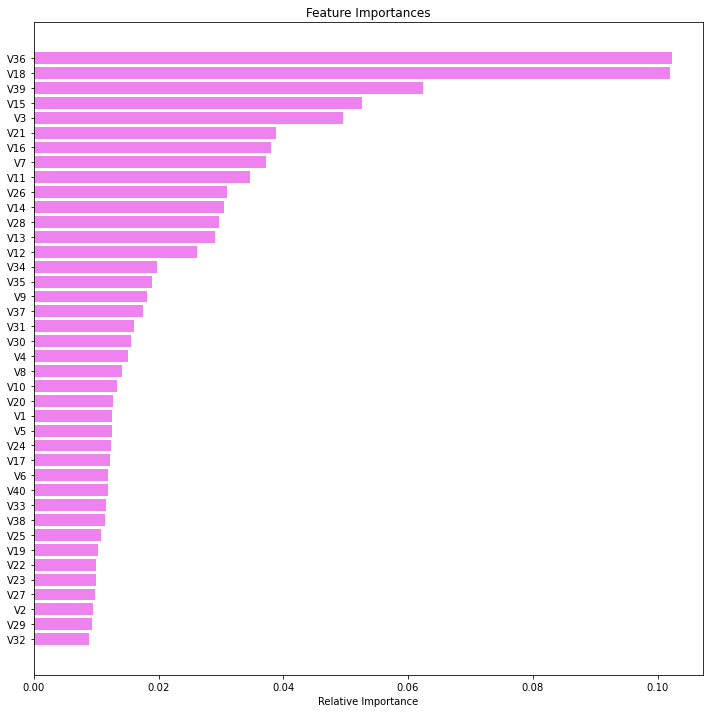

In [113]:
#Although details are encrypted, renewind can allow their employees to decode the data and use this feature importance chart to determine which features are the most fritical to a turbines maintanance.
feature_names = X_train.columns
importances = tuned_rf_under.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### Observations
- While the data is encrypted, Renewind employees could un encrypt the information and use the graph above to evaluate what parameters are the most critical to a turbines health.

### Final model Pipeline

In [114]:
# Creating new pipeline with best parameters
model = Pipeline(steps=[
    ("RandomForest", RandomForestClassifier(
        max_features='sqrt',
        random_state=1,
        max_samples=0.5,
        n_estimators=300,
        min_samples_leaf=2,
    ))
])

model.fit(X_train_under, y_train_under)

Pipeline(steps=[('RandomForest',
                 RandomForestClassifier(max_features='sqrt', max_samples=0.5,
                                        min_samples_leaf=2, n_estimators=300,
                                        random_state=1))])

In [115]:
# Separating target variable and other variables
X1 = data.drop(columns="Target")
Y1 = data["Target"]

X_test1 = df_test.drop(columns="Target") 
y_test1 = df_test['Target']

In [116]:
# We can't oversample/undersample data without doing missing value treatment, so let's first treat the missing values in the train set
imputer = SimpleImputer(strategy="median")
X1 = imputer.fit_transform(X1)

# We don't need to impute missing values in test set as it will be done inside pipeline

In [117]:
# Under Sampling Technique
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [118]:
# Assuming you have already separated the target variable and features (X_train and y_train)

# Create an imputer to handle missing values
imputer = SimpleImputer(strategy="median")

# Create a RandomUnderSampler to balance the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)

# Create the pipeline with RandomUnderSampler and RandomForestClassifier
model = ImbPipeline(steps=[
    ("undersampler", rus),  # Add the undersampler as the first step
    ("RandomForest", RandomForestClassifier(
        max_features='sqrt',
        random_state=1,
        max_samples=0.5,
        n_estimators=300,
        min_samples_leaf=2,
    ))
])

# Fit the pipeline with training data
model.fit(X1, Y1)  # Use X1 and Y1 here instead of X_train and y_train, as you've used them in the code snippet above

# For the testing data, you can use it directly without resampling as it was not used for training the model.
# Assuming you have already processed the test data and stored it in X_test1 and y_test1

# Make predictions with the trained model
y_pred = model.predict(X_test)

## **Apply the final model to final test data using the pipeline**

In [119]:
Pipeline_model_test = model_performance_classification_sklearn(model, X_test, y_test)
Pipeline_model_test

,Accuracy,Recall,Precision,F1
0,0.945,0.872,0.507,0.641


#### Observations
- Our final random forest undersampled model returned strong recall results on the unseen test data.  The recall score of 0.87 was close the the 0.88 achieved on the validation set and slightly below the 0.93 achieved on the training data.
- While these test results are fairly strong their distance form the training and validation results indicate some overfit in our model. In the future we could try a greater variety of hyperparameters to the random search CV or try using grid search instead to minimize this overfit.  

# Business Insights and Conclusions

#### Insights
By applying our final model (Randomforest trained with undersampled data) to Renewind's turbine data, we can confidently predict their turbine failures around 85-90% of the time. By more accuractly identifying turbine failure, Renewind can quickly do maintenance on these turbines avoiding the need for a full replacement. This will save money as well as reduce the material and logistical difficulties asscoiated with replacement, alowing the turbine to go back on line and continue providing electricity to the grid.
- The model does a good job of maximizing Recall but performs poorly for Precision and F1.  If renewind deploys our model and want to avoid spending money on fixing turbines falsly identified as having failed, additional models must be built on 'failed' turbine data to avoid spending on these incorrectly identified, nbut still functioning turbines.
   
While the encryption of the data makes in depth analysis difficult, we can still highlight several important relationships, or lack there of, for Renewinds internal team to investigate when looking at their unencrypted data.
- None of the 40 parameters measured by Renewind have a strong positive or native correlation with the target variable. Either turbine failure is due to a combination of many factors, or the dataset if convoluted with multicoliniarity and should be split into pieces for more granular analysis
- v36, v18, v39, v15 and v3 were indentified by our model as the most important features with regard to turbine failure.


 
#### Recommendations
- Using our feature importance chanrt, Renewind should encourage their engineers to improve the components of the turbines that contribute most to failure. 

- Renewind should consider breaking the evaluation metrics (parameters) into smaller subsets and evaluating these subsets individually.  None of the parameters in the dataset provided show a great deal of positive or negative correlation to the target variable. This could be do to the multicolinearity included in such a large data set.  by breaking the data into groups such as weather related data (wind speed, temp, rainfall, etc), machine health data  (months since last service, rotor speed, watts produces, gearbox, etc.) and other groupings, we could evaluate each group individually and zero in on the parameters that have the greatest influence on turbine failure.  This would allow Renewind's R and D department to engineer solutions to those specific problems as opposed to playing catch up with machine failures.

- While data security is certainly important, Renewind should consider allowing the data science team to access their unencrypted data.  While the model above can predict turbine failure, the unencrypted parameter values would allow for deeper analysis into which variables have the greatest influence on turbine failure.  Our feature importance chart give us some indication of this, showing that parameters such as v36, v18, v39, etc. could have significant influence but the unencrypted data would allow data scientists to better understand the important variables and perform bivariate analysis investigating their relationship to one another. 

